In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Dense, Input

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung


In [5]:
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [6]:
img_width, img_height = 224, 224
train_data_dir = 'data/chapter_3/training_set'
test_data_dir = 'data/chapter_3/test_set'

In [7]:
model = applications.VGG16(weights = 'imagenet',
                           include_top = False, # whether to include the 3 fully-connected layers at the top network
                           input_shape = (img_width, img_height, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## **New dataset is small and similar to original dataset**

### **Freeze toàn bộ layers và chỉ train lại classifier**

In [9]:
# đóng băng lại phần convolutional base
for layer in model.layers:
  layer.trainable = False

In [10]:
# adding custom layers - ANN
x = model.output 
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)


# binary output:
## nếu output = 2 thì nếu result sẽ ra 2 giá trị, căn cứ theo xác suất mà là cat or dog
## nếu output = 1 thì nếu < 0.5 thì là cat, >=0.5 là dog
predictions = Dense(2, activation="sigmoid")(x)

In [11]:
model_final = Model(inputs = model.input, outputs = predictions)

In [12]:
# complile model
model_final.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9), # dataset lớn nên dùng adam, ở đây dataset nhỏ có thể dùng SGD
                    metrics=['accuracy'])

In [13]:
# Initiate the train and test generators with data Augumentation 
#  horizontal_flip = True: lật nè

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range=0.3,
                                   rotation_range=30)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [14]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height, 
                                                                   img_width),
                                                    batch_size = 32, 
                                                    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(test_data_dir,
                                                    target_size = (img_height, 
                                                                   img_width),
                                                    class_mode = "categorical")


Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [15]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("Chapter_5_Pretrain_Model/model_checkpoint/dog_cat_vgg16_cp_new.h5", 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq=1)
early = EarlyStopping(monitor='val_loss', 
                      min_delta=0.001, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')


In [16]:
import datetime
t0 = datetime.datetime.now()

In [17]:
# steps_per_epoch = len(train_generator): để cũng dc, bỏ cũng dc:)), có thể thay = batch_size
history = model_final.fit(train_generator,
                          steps_per_epoch = len(train_generator),
                          epochs = 100,
                          validation_data = validation_generator,
                          validation_steps = len(validation_generator), 
                          callbacks = [checkpoint, early],
                          verbose=1)

Epoch 1/100
7/7 [==============================] - 53s 7s/step - loss: 0.7857 - accuracy: 0.5200 - val_loss: 0.7383 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 3s 473ms/step - loss: 0.7660 - accuracy: 0.4950 - val_loss: 0.7149 - val_accuracy: 0.5000
Epoch 3/100
7/7 [==============================] - 4s 509ms/step - loss: 0.7217 - accuracy: 0.5100 - val_loss: 0.6688 - val_accuracy: 0.6100
Epoch 4/100
7/7 [==============================] - 4s 477ms/step - loss: 0.7063 - accuracy: 0.5450 - val_loss: 0.6565 - val_accuracy: 0.5700
Epoch 5/100
7/7 [==============================] - 3s 491ms/step - loss: 0.7431 - accuracy: 0.5200 - val_loss: 0.6907 - val_accuracy: 0.5100
Epoch 6/100
7/7 [==============================] - 3s 481ms/step - loss: 0.7231 - accuracy: 0.5550 - val_loss: 0.6208 - val_accuracy: 0.7500
Epoch 7/100
7/7 [==============================] - 3s 489ms/step - loss: 0.7297 - accuracy: 0.5350 - val_loss: 0.6673 - val_accuracy: 0.5200
Epoch 8/100
7/7

In [18]:
t1 = datetime.datetime.now()
t1 - t0

datetime.timedelta(seconds=324, microseconds=749223)

In [19]:
print(t1 - t0)

0:05:24.749223


In [20]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.785667,0.520,0.738337,0.50
1,0.766042,0.495,0.714923,0.50
2,0.721728,0.510,0.668776,0.61
3,0.706301,0.545,0.656464,0.57
4,0.743098,0.520,0.690677,0.51


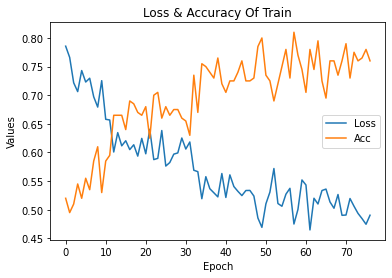

In [21]:
# loss và acc của train
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Loss & Accuracy Of Train')
plt.ylabel('Values')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Acc'])
plt.show()

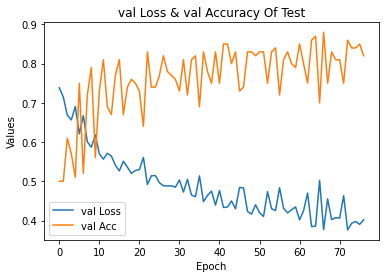

In [22]:
# loss và acc của test
plt.figure()
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.title('val Loss & val Accuracy Of Test')
plt.ylabel('Values')
plt.xlabel('Epoch')
plt.legend(['val Loss', 'val Acc'])
plt.show()

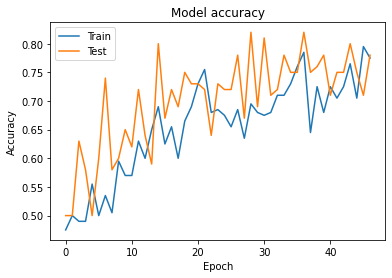

In [ ]:
plt.figure()
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

### **Save model**

In [ ]:
from tensorflow.keras.models import load_model
model_final.save('Chapter_5_Pretrain_Model/model/chapter_dog_cat_vgg16.h5')

### **Prediction**

In [ ]:
#read model
model_new = load_model('Chapter_5_Pretrain_Model/model/chapter_dog_cat_vgg16.h5')

In [ ]:
def print_result(test_image):
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model_new.predict(test_image)
    print(result)
    #training_set.class_indices
    if result[0][0] > result[0][1]:
        prediction = 'cat'
    else:
        prediction = 'dog'
    print(prediction)


In [ ]:
test_image = image.load_img('data/chapter_3/single_prediction/dog1.jpg', target_size = (224,224))

print_result(test_image)

[[1.4103889e-13 9.7718537e-01]]
dog


In [ ]:
'''
xác suất theo thứ tự alpha beta
[[1.4103889e-13 9.7718537e-01]]: nghĩa là xác xuất là cat: 1.4103889e-13; xác suất là dog: 9.7718537e-01

test_image[0][0] = 0, test_image[0][1] = 0 => dog
'''

'\ntest_image[0][0] = 0, test_image[0][1] = 0 => dog\n'

In [23]:
import matplotlib.image as mpimg
def show_result(path, model, img_size):
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()


    test_image = image.load_img(path, target_size = img_size) 
    test_image.show()
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    print(result)


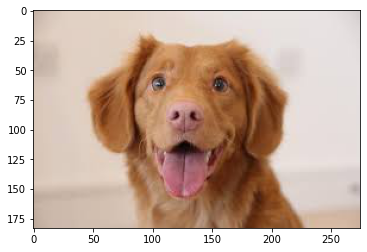

[[2.1006018e-11 1.0000000e+00]]


In [27]:
path = 'data/chapter_3/single_prediction/dog1.jpg'

show_result(path, model_final, (img_width, img_height))